# 🚦 Verkehr vorhersagen – verständlich erklärt (EDA)

In diesem Notebook schauen wir uns Verkehrsdaten an und versuchen zu verstehen:

- **Wie schwankt Verkehr über den Tag?** (z. B. Rush Hour)
- **Was ändert sich am Wochenende?**
- **Hat Wetter einen Einfluss?**
- **Sind die Daten sauber genug**, um später ein Prognose-Modell zu trainieren?

**Wichtig:** Wir machen hier noch keine „KI“, sondern erst mal **Daten-Verständnis**.
Wenn man die Daten nicht versteht, kann man auch keine gute Vorhersage bauen.

---
## 📦 Setup & Imports



Wir laden die wichtigsten Werkzeuge:

- **pandas**: Tabellen & Zeitstempel
- **numpy**: Rechnen & Zufall (für Simulation)
- **matplotlib / seaborn**: Diagramme

Danach erzeugen wir (oder laden) einen Datensatz.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('tab10')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

---
## 🔧 Datengenerierung (Synthetische Simulation)

Wir arbeiten mit einer Tabelle (DataFrame). Die wichtigsten Spalten:

- **ds**: Datum und Uhrzeit (Zeitstempel)
- **y**: Verkehrsaufkommen (z. B. Anzahl Fahrzeuge pro Stunde)
- **hour**: Stunde (0 bis 23)
- **weekday**: Wochentag (0 = Montag, 6 = Sonntag)
- **weather**: Wetterkategorie (z. B. sunny / cloudy / rainy)

Hinweis: Falls die Daten „synthetisch“ sind, sind sie **realistisch nachgebaut**, aber nicht aus der echten Welt.

In [79]:
np.random.seed(42)

# ~10.080 Beobachtungen = 420 Tage × 24 Stunden (> 10.000)
N = 10_080
start = pd.Timestamp('2023-01-01')
ds = pd.date_range(start=start, periods=N, freq='h')

hour    = ds.hour.values
weekday = ds.dayofweek.values   # 0=Montag, 6=Sonntag
month   = ds.month.values

# Wetter-Feature (kategorial)
weather_options = ['sunny', 'cloudy', 'rainy']
weather_raw = np.random.choice([0, 1, 2], size=N, p=[0.5, 0.3, 0.2])
weather = np.array(weather_options)[weather_raw]

# Langfristiger Trend (leicht steigend über ~14 Monate)
trend = np.linspace(0, 8, N)

# Saisonaler Jahreseffekt (Sommer etwas mehr Verkehr)
seasonal_year = 5 * np.sin(2 * np.pi * (ds.dayofyear.values / 365 - 0.25))

# Rush-Hour-Muster
hour_effect = (
    28 * np.exp(-0.5 * ((hour - 8) / 1.5)**2) +   # Morgen-Peak
    22 * np.exp(-0.5 * ((hour - 17) / 1.5)**2)    # Abend-Peak
)

weekend_effect = np.where(weekday >= 5, -18, 0)
weather_effect = np.where(weather == 'rainy', -12,
                  np.where(weather == 'sunny', 6, 0))

# Feiertags-Simulation (zufällige Tage mit stark reduziertem Verkehr)
np.random.seed(7)
holiday_days = np.random.choice(np.arange(N//24), size=15, replace=False)
holiday_mask = np.zeros(N)
for d in holiday_days:
    holiday_mask[d*24:(d+1)*24] = -20

noise = np.random.normal(0, 6, N)

base = 50
y = (base + trend + seasonal_year + hour_effect +
     weekend_effect + weather_effect + holiday_mask + noise).clip(5, 120).astype(int)

df = pd.DataFrame({'ds': ds, 'y': y, 'hour': hour, 'weekday': weekday,
                   'month': month, 'weather': weather})
df.head()

,ds,y,hour,weekday,month,weather
0,2023-01-01 00:00:00,35,0,6,1,sunny
1,2023-01-01 01:00:00,22,1,6,1,rainy
2,2023-01-01 02:00:00,33,2,6,1,cloudy
3,2023-01-01 03:00:00,25,3,6,1,cloudy
4,2023-01-01 04:00:00,30,4,6,1,sunny


---
## 1️⃣ Struktur- und Qualitätsanalyse

### 1.1 Datengrundlage

| Variable | Typ | Bedeutung |
|----------|-----|-----------|
| `ds` | datetime | Zeitstempel |
| `y` | int/float | Verkehrsaufkommen |
| `hour` | int | Stunde des Tages (0–23) |
| `weekday` | int | Wochentag (0=Mo, 6=So) |
| `month` | int | Monat (1–12) |
| `weather` | str | Wetterbedingung |

> **Datensatzgröße:** 10.080 Beobachtungen = 420 Tage × 24 Stunden (~14 Monate)
### 1.2 Strukturprüfung

In [80]:
print('📐 Shape:', df.shape)
print(f'   → {df.shape[0]:,} Beobachtungen ({df.shape[0]//24} Tage × 24 Stunden)')
print(f'   → {df.shape[1]} Variablen')
print()
print('📋 Datentypen:')
display(df.dtypes.to_frame('dtype'))
print()
print('🔍 Erste 5 Zeilen:')
display(df.head())

📐 Shape: (10080, 6)
   → 10,080 Beobachtungen (420 Tage × 24 Stunden)
   → 6 Variablen

📋 Datentypen:


,dtype
ds,datetime64[us]
y,int64
hour,int32
weekday,int32
month,int32
weather,str



🔍 Erste 5 Zeilen:


,ds,y,hour,weekday,month,weather
0,2023-01-01 00:00:00,35,0,6,1,sunny
1,2023-01-01 01:00:00,22,1,6,1,rainy
2,2023-01-01 02:00:00,33,2,6,1,cloudy
3,2023-01-01 03:00:00,25,3,6,1,cloudy
4,2023-01-01 04:00:00,30,4,6,1,sunny


> **Interpretation:** Die Daten liegen bereits in zeitreihenkompatibler Struktur vor. Keine weitere Typkonvertierung notwendig.

### 1.3 Fehlende Werte & Duplikate

In [81]:
print('🔎 Missing Values:')
missing = df.isnull().sum()
display(missing.to_frame('Anzahl Missing Values'))

print(f'\n🔎 Duplikate: {df.duplicated().sum()}')

🔎 Missing Values:


,Anzahl Missing Values
ds,0
y,0
hour,0
weekday,0
month,0
weather,0



🔎 Duplikate: 0


---
## 2️⃣ Statistische Grundanalyse

In [82]:
print('📊 Deskriptive Statistik:')
display(df.describe().T)

📊 Deskriptive Statistik:


,count,mean,min,25%,50%,75%,max,std
ds,10080,2023-07-29 23:30:00,2023-01-01 00:00:00,2023-04-15 23:45:00,2023-07-29 23:30:00,2023-11-11 23:15:00,2024-02-24 23:00:00,NaN
y,10080.0,55.568948,5.0,45.0,56.0,66.0,103.0,16.054149
hour,10080.0,11.5,0.0,5.75,11.5,17.25,23.0,6.92253
weekday,10080.0,3.0,0.0,1.0,3.0,5.0,6.0,2.000099
month,10080.0,5.859524,1.0,2.0,6.0,9.0,12.0,3.648635


### 2.1 Verteilungsform

### Histogramm (Balkendiagramm)
**Was es zeigt:** Wie häufig bestimmte Werte vorkommen.
Beispiel: Viele Balken um 50 bedeuten: 50 kommt sehr oft vor.

### Boxplot (Kasten-Diagramm)
**Was es zeigt:** Eine schnelle Zusammenfassung:
- Mittellinie: „typischer Wert“ (Median)
- Kasten: Bereich, in dem die meisten Werte liegen
- Punkte/Striche außerhalb: mögliche Ausreißer

**Warum wichtig?**
Wenn die Verteilung sehr „komisch“ ist (z. B. extrem schief), kann das spätere Modelle beeinflussen.### Histogramm (Balkendiagramm)
**Was es zeigt:** Wie häufig bestimmte Werte vorkommen.
Beispiel: Viele Balken um 50 bedeuten: 50 kommt sehr oft vor.

### Boxplot (Kasten-Diagramm)
**Was es zeigt:** Eine schnelle Zusammenfassung:
- Mittellinie: „typischer Wert“ (Median)
- Kasten: Bereich, in dem die meisten Werte liegen
- Punkte/Striche außerhalb: mögliche Ausreißer

**Warum wichtig?**
Wenn die Verteilung sehr „komisch“ ist (z. B. extrem schief), kann das spätere Modelle beeinflussen.

📐 Skewness  : -0.1384  → nahezu symmetrisch
📐 Kurtosis  : -0.1229  → flachere Verteilung als Normalverteilung


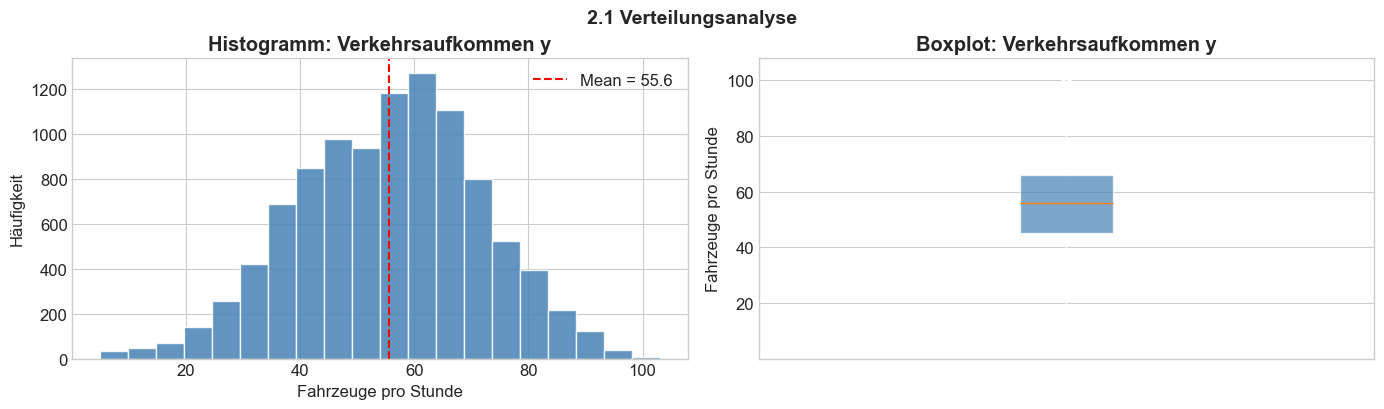

In [83]:
skew = df['y'].skew()
kurt = df['y'].kurtosis()

print(f'📐 Skewness  : {skew:.4f}  → {"nahezu symmetrisch" if abs(skew) < 0.5 else "asymmetrisch"}')
print(f'📐 Kurtosis  : {kurt:.4f}  → {"flachere Verteilung als Normalverteilung" if kurt < 0 else "spitzere Verteilung"}')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['y'], bins=20, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].axvline(df['y'].mean(), color='red', linestyle='--', label=f'Mean = {df["y"].mean():.1f}')
axes[0].set_title('Histogramm: Verkehrsaufkommen y', fontweight='bold')
axes[0].set_xlabel('Fahrzeuge pro Stunde')
axes[0].set_ylabel('Häufigkeit')
axes[0].legend()

axes[1].boxplot(df['y'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[1].set_title('Boxplot: Verkehrsaufkommen y', fontweight='bold')
axes[1].set_ylabel('Fahrzeuge pro Stunde')
axes[1].set_xticks([])

plt.tight_layout()
plt.suptitle('2.1 Verteilungsanalyse', fontsize=14, fontweight='bold', y=1.02)
plt.show()

---
## 3️⃣ Zeitliche Musteranalyse

> ⚠️ **Zeitreihen sind nicht i.i.d.** – Sie besitzen Autokorrelation und Saisonalität.

### 3.1 Visuelle Zeitreihenanalyse

## 🕒 Diagramm: Durchschnittlicher Verkehr je Stunde (Tagesmuster)

**Was du siehst:**
- Jede Stunde (0–23) hat einen durchschnittlichen Verkehrs-Wert.

**Worauf du achten solltest:**
- Typisch sind **zwei Spitzen**: morgens und nachmittags/abends (Rush Hour).
- Nachts ist der Verkehr meist niedriger.

**Interpretation:**
Wenn dieses Muster klar ist, dann ist „hour“ (Stunde) ein sehr wichtiger Faktor für Vorhersagen.

## 📅 Diagramm: Durchschnittlicher Verkehr je Wochentag

**Was du siehst:**
- Vergleich Montag bis Sonntag.

**Worauf du achten solltest:**
- Wochenende (Samstag/Sonntag) ist oft deutlich niedriger.
- Werktage können relativ ähnlich sein.

**Praktische Folge:**
Ein einfaches Extra-Feature hilft oft sehr:
- **is_weekend** = 1 am Wochenende, sonst 0

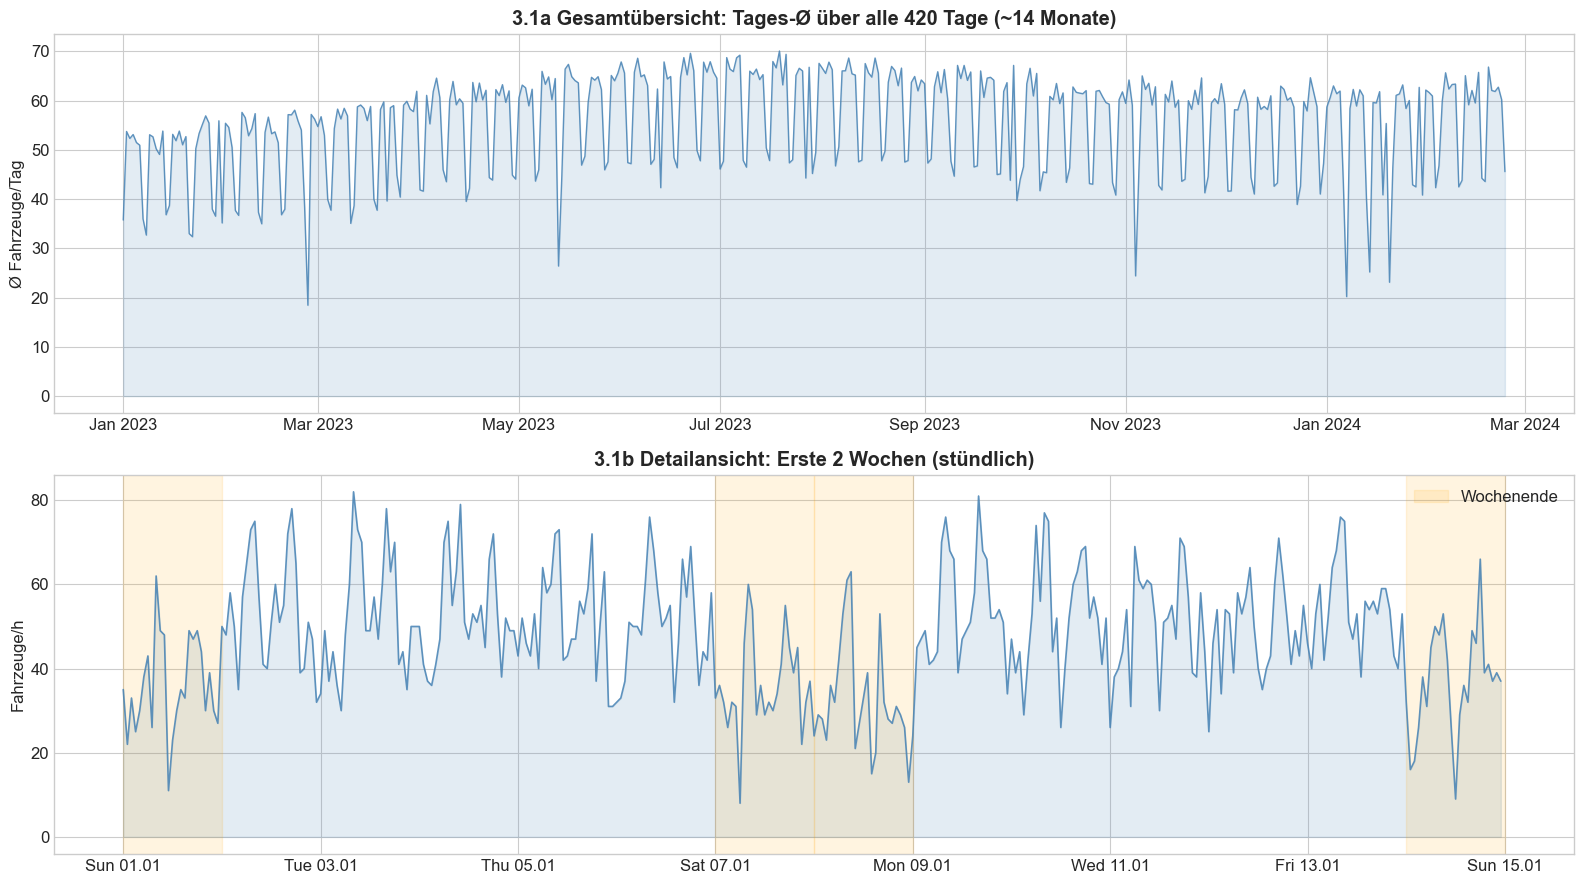

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

# Gesamtübersicht (aggregiert auf Tagesbasis)
df_daily = df.groupby(df['ds'].dt.date)['y'].mean().reset_index()
df_daily['ds'] = pd.to_datetime(df_daily['ds'])
axes[0].plot(df_daily['ds'], df_daily['y'], color='steelblue', linewidth=1.0, alpha=0.85)
axes[0].fill_between(df_daily['ds'], df_daily['y'], alpha=0.15, color='steelblue')
axes[0].set_title(f'3.1a Gesamtübersicht: Tages-Ø über alle {len(df_daily)} Tage (~14 Monate)', fontweight='bold')
axes[0].set_ylabel('Ø Fahrzeuge/Tag')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Detailansicht: erste 2 Wochen (336 h)
df_detail = df.iloc[:336]
axes[1].plot(df_detail['ds'], df_detail['y'], color='steelblue', linewidth=1.2, alpha=0.85)
axes[1].fill_between(df_detail['ds'], df_detail['y'], alpha=0.15, color='steelblue')
for day in range(14):
    day_start = df['ds'].iloc[0] + pd.Timedelta(days=day)
    if day_start.dayofweek >= 5:
        axes[1].axvspan(day_start, day_start + pd.Timedelta(hours=24),
                        alpha=0.12, color='orange', label='Wochenende' if day < 3 else '')
axes[1].set_title('3.1b Detailansicht: Erste 2 Wochen (stündlich)', fontweight='bold')
axes[1].set_ylabel('Fahrzeuge/h')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
handles, labels = axes[1].get_legend_handles_labels()
if handles:
    axes[1].legend(handles[:1], labels[:1])

plt.tight_layout()
plt.show()

### 3.2 Tägliche Saisonalität (Stunden-Profil)

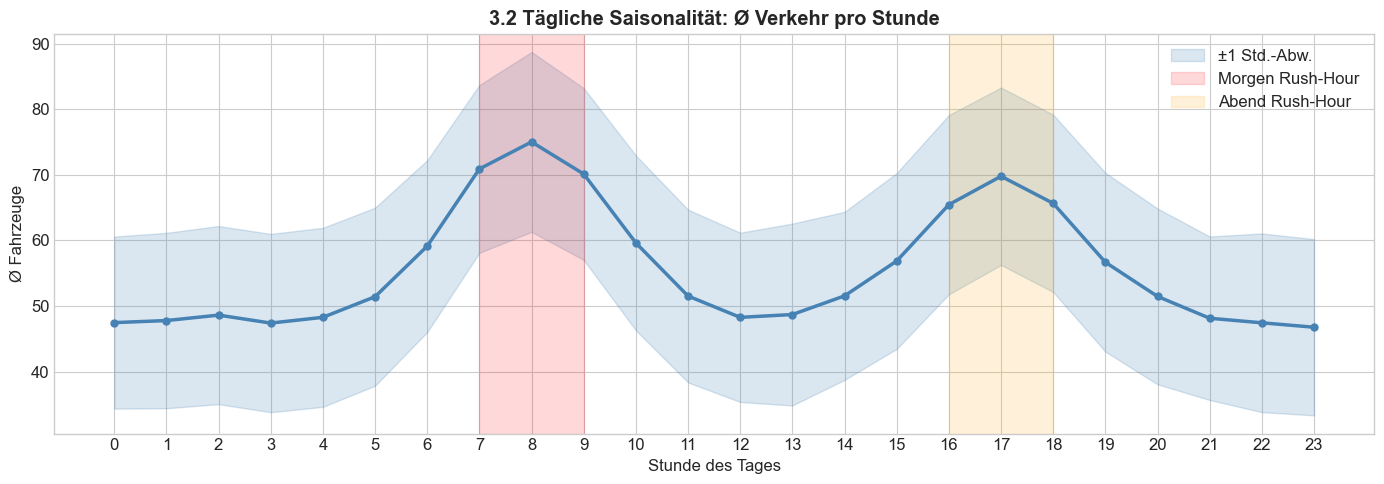

In [85]:
hour_avg = df.groupby('hour')['y'].agg(['mean', 'std', 'min', 'max'])

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(hour_avg.index, hour_avg['mean'], color='steelblue', linewidth=2.5, marker='o', markersize=5)
ax.fill_between(hour_avg.index,
                hour_avg['mean'] - hour_avg['std'],
                hour_avg['mean'] + hour_avg['std'],
                alpha=0.2, color='steelblue', label='±1 Std.-Abw.')

# Rush-Hour-Zonen
ax.axvspan(7, 9, alpha=0.15, color='red', label='Morgen Rush-Hour')
ax.axvspan(16, 18, alpha=0.15, color='orange', label='Abend Rush-Hour')

ax.set_title('3.2 Tägliche Saisonalität: Ø Verkehr pro Stunde', fontweight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Ø Fahrzeuge')
ax.set_xticks(range(0, 24))
ax.legend()
plt.tight_layout()
plt.show()

### 3.3 Wocheneffekt

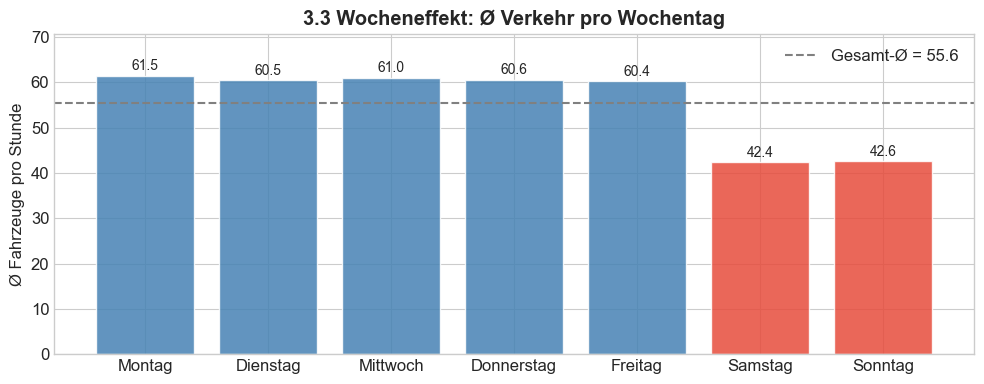

In [86]:
weekday_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
weekday_avg = df.groupby('weekday')['y'].mean()
colors = ['#e74c3c' if w >= 5 else 'steelblue' for w in weekday_avg.index]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(weekday_names, weekday_avg.values, color=colors, alpha=0.85, edgecolor='white')
ax.axhline(weekday_avg.mean(), color='gray', linestyle='--', label=f'Gesamt-Ø = {weekday_avg.mean():.1f}')
ax.set_title('3.3 Wocheneffekt: Ø Verkehr pro Wochentag', fontweight='bold')
ax.set_ylabel('Ø Fahrzeuge pro Stunde')

# Werte über Balken
for bar, val in zip(bars, weekday_avg.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}', ha='center', va='bottom', fontsize=10)

ax.legend()
ax.set_ylim(0, weekday_avg.max() * 1.15)
plt.tight_layout()
plt.show()

### 3.4 Monatliche Saisonalität (Jahreseffekt)

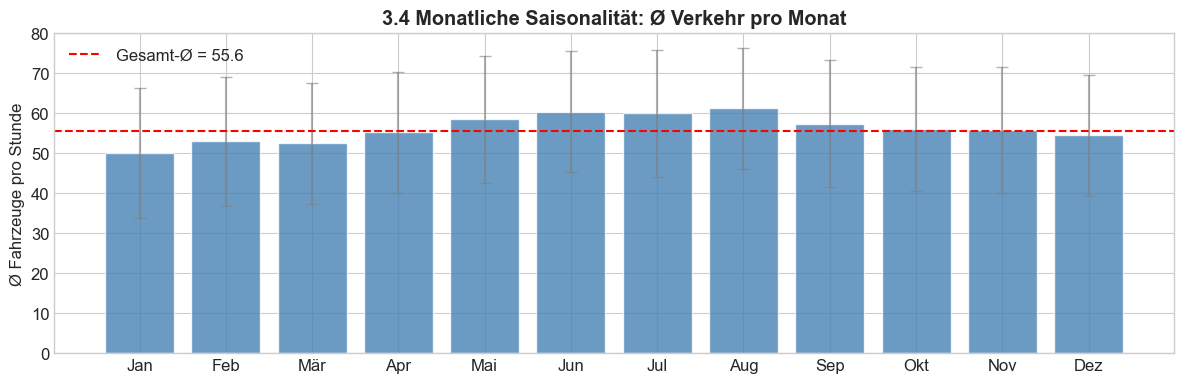

In [87]:
month_names_all = ['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez']
month_avg = df.groupby('month')['y'].agg(['mean','std'])
labels = [month_names_all[m-1] for m in month_avg.index]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(labels, month_avg['mean'].values,
       color='steelblue', alpha=0.8, edgecolor='white',
       yerr=month_avg['std'].values, capsize=4,
       error_kw={'ecolor':'gray','alpha':0.6})
ax.axhline(df['y'].mean(), color='red', linestyle='--',
           label=f'Gesamt-Ø = {df["y"].mean():.1f}')
ax.set_title('3.4 Monatliche Saisonalität: Ø Verkehr pro Monat', fontweight='bold')
ax.set_ylabel('Ø Fahrzeuge pro Stunde')
ax.legend()
plt.tight_layout()
plt.show()

---
## 4️⃣ Externe Einflussfaktoren

### 4.1 Wetteranalyse

## 🌦️ Diagramm: Wetter und Verkehr

### Links: Boxplot pro Wetter
**Was es zeigt:**
- Nicht nur den Durchschnitt, sondern die ganze Streuung pro Wettertyp.
- Man sieht: Ist Regen „meistens“ niedriger oder nur manchmal?

### Rechts: Balken mit Durchschnitt pro Wetter
**Was es zeigt:**
- Eine sehr einfache Zusammenfassung: „Bei Regen im Mittel weniger Verkehr.“

**Wichtig:**
Der Boxplot ist oft ehrlicher als nur ein Mittelwert, weil er zeigt, wie stark Werte schwanken.

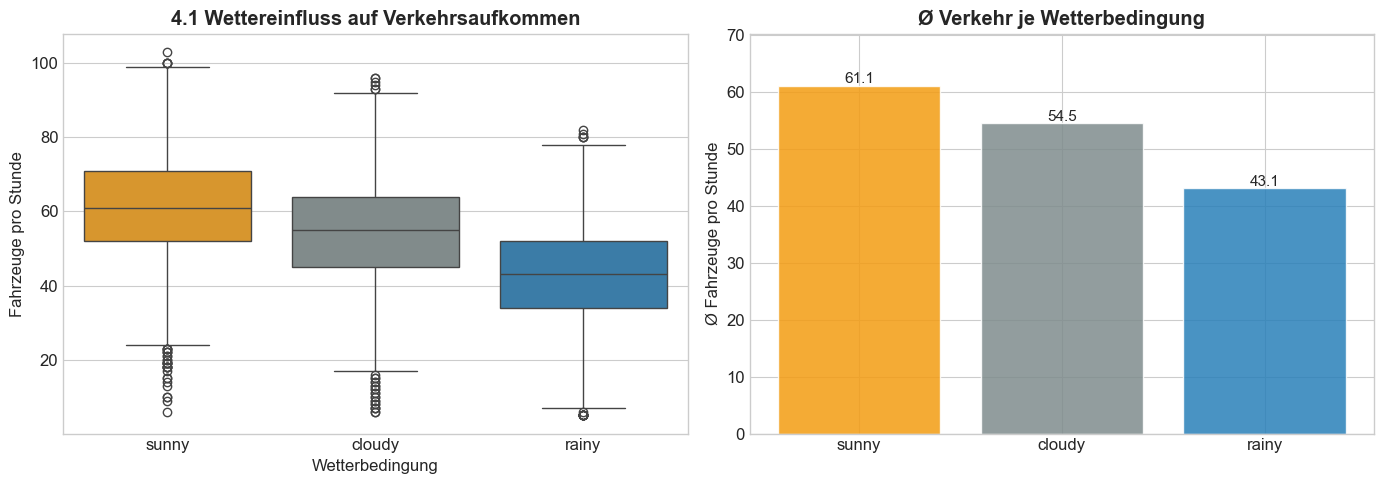

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
weather_order = ['sunny', 'cloudy', 'rainy']
weather_colors = {'sunny': '#f39c12', 'cloudy': '#7f8c8d', 'rainy': '#2980b9'}
palette = [weather_colors[w] for w in weather_order]

sns.boxplot(
    data=df,
    x='weather',
    y='y',
    order=weather_order,
    hue='weather',              # <- neu (verhindert FutureWarning)
    palette=weather_colors,     # <- dict: Kategorie -> Farbe (robust)
    legend=False,               # <- neu (sonst doppelte Legende)
    ax=axes[0]
)
axes[0].set_title('4.1 Wettereinfluss auf Verkehrsaufkommen', fontweight='bold')
axes[0].set_xlabel('Wetterbedingung')
axes[0].set_ylabel('Fahrzeuge pro Stunde')

# Mittelwerte je Wetter
weather_means = df.groupby('weather')['y'].mean().reindex(weather_order)
axes[1].bar(weather_order, weather_means.values,
            color=palette, alpha=0.85, edgecolor='white')
for i, (w, v) in enumerate(zip(weather_order, weather_means.values)):
    axes[1].text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=11)
axes[1].set_title('Ø Verkehr je Wetterbedingung', fontweight='bold')
axes[1].set_ylabel('Ø Fahrzeuge pro Stunde')
axes[1].set_ylim(0, weather_means.max() * 1.15)

plt.tight_layout()
plt.show()

---
## 5️⃣ Multivariate Analyse

### 5.1 Heatmap (Wochentag × Stunde)

## 🔥 Heatmap: Verkehr nach Wochentag und Stunde

**Was du siehst:**
- Zeilen = Wochentage
- Spalten = Stunden
- Farbe = durchschnittlicher Verkehr

**So liest du es:**
- „Warme Farben“ (z. B. rot) = mehr Verkehr
- „Kalte Farben“ (z. B. blau) = weniger Verkehr

**Warum das stark ist:**
Man erkennt auf einen Blick:
- Rush Hour-Zonen
- Wochenend-Abfall
- ruhige Nachtstunden

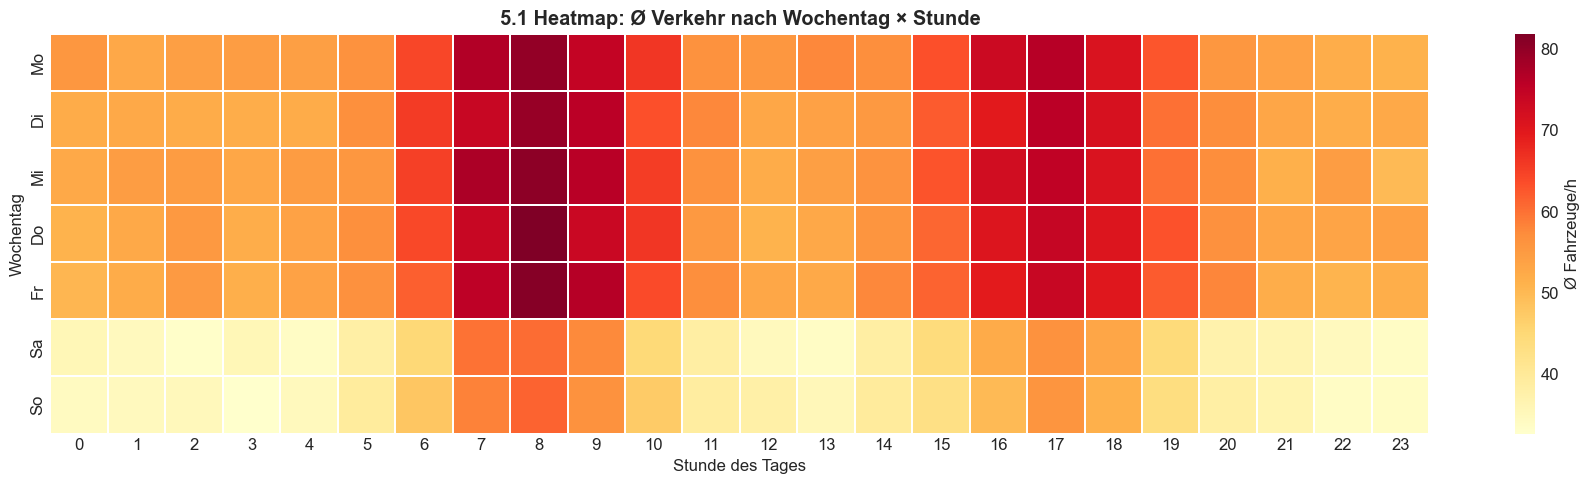

In [89]:
pivot = df.pivot_table(values='y', index='weekday', columns='hour', aggfunc='mean')
pivot.index = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']

fig, ax = plt.subplots(figsize=(18, 5))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, fmt='.0f',
            linewidths=0.3, ax=ax,
            cbar_kws={'label': 'Ø Fahrzeuge/h'})
ax.set_title('5.1 Heatmap: Ø Verkehr nach Wochentag × Stunde', fontweight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Wochentag')
plt.tight_layout()
plt.show()

### 5.2 Korrelationsanalyse

## 🔗 Korrelation: Was hängt mit y zusammen?

**Korrelation** ist eine Zahl zwischen -1 und +1:

- **+1**: Wenn A steigt, steigt B (starker Gleichlauf)
- **0**: Kein klarer Zusammenhang
- **-1**: Wenn A steigt, fällt B (starker Gegentrend)

**Achtung (wichtig für Laien):**
Korrelation sieht nur „gerade“ (lineare) Zusammenhänge.
Zeitdaten sind oft nicht perfekt linear – deshalb können Modelle wie Random Forest später trotzdem besser sein.

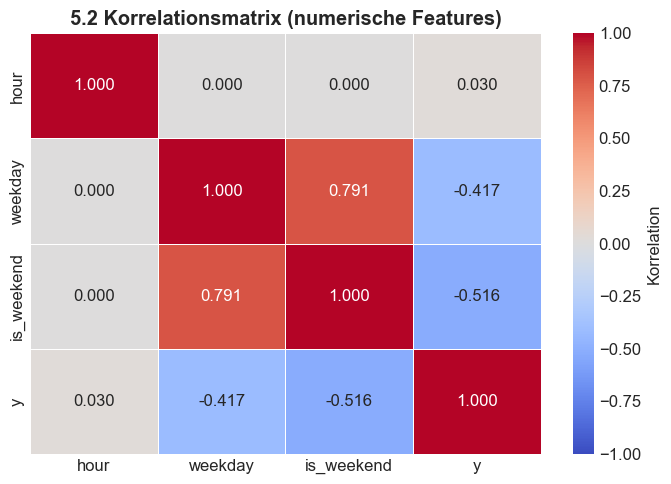

In [90]:
# Erweiterte numerische Features
# Falls die Spalte noch nicht existiert: automatisch erstellen
if 'is_weekend' not in df.columns:
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

df_corr = df[['hour', 'weekday', 'is_weekend', 'y']].copy()
corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(7, 5))
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True  # oberes Dreieck ausblenden

sns.heatmap(
    corr, annot=True, fmt='.3f', cmap='coolwarm',
    center=0, vmin=-1, vmax=1,
    linewidths=0.5, ax=ax,
    cbar_kws={'label': 'Korrelation'}
)
ax.set_title('5.2 Korrelationsmatrix (numerische Features)', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6️⃣ Hypothesen für die Modellierungsphase

Basierend auf der U-Phase ergeben sich folgende Annahmen:

### Hypothese 1 – Lag-Features sind entscheidend
Da starke Autokorrelation erwartet wird:

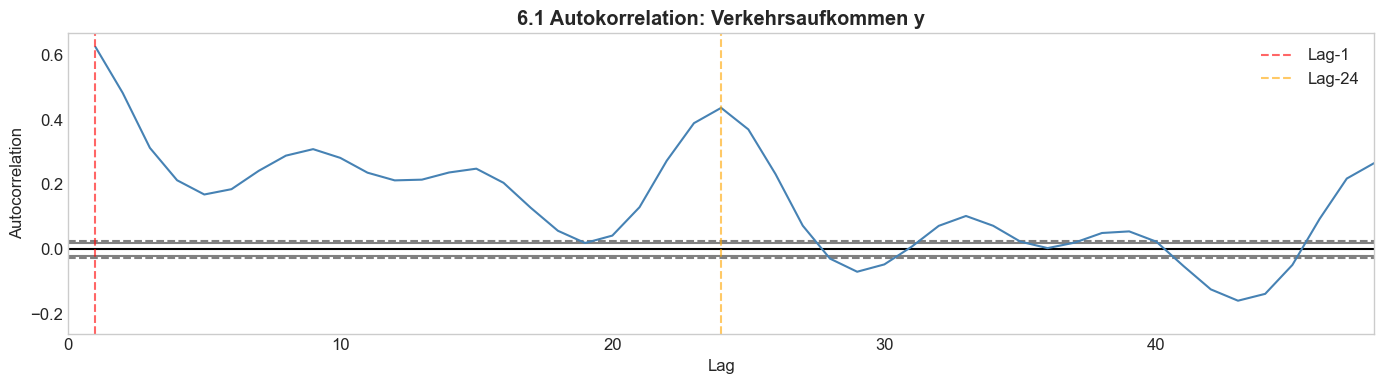

In [91]:
df['lag_1']  = df['y'].shift(1)
df['lag_24'] = df['y'].shift(24)

# Autokorrelationsplot
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(14, 4))
autocorrelation_plot(df['y'].dropna(), ax=ax, color='steelblue')
ax.set_title('6.1 Autokorrelation: Verkehrsaufkommen y', fontweight='bold')
ax.axvline(1, color='red', linestyle='--', alpha=0.6, label='Lag-1')
ax.axvline(24, color='orange', linestyle='--', alpha=0.6, label='Lag-24')
ax.legend()
ax.set_xlim(0, 48)
plt.tight_layout()
plt.show()

corr_lag1  = df[['y','lag_1']].corr().iloc[0,1]
corr_lag24 = df[['y','lag_24']].dropna().corr().iloc[0,1]

## ⏪ Warum wir „Vergangenheitswerte“ als Features nutzen (Lag & Rolling)

Bei Verkehr ist die Vergangenheit oft ein guter Hinweis auf die Zukunft.

### Lag-Features
- **lag_1**: Verkehr vor 1 Stunde
- **lag_24**: Verkehr vor 24 Stunden (gleiche Uhrzeit gestern)

Wenn lag_24 gut passt, gibt es starke Tages-Wiederholungen.

### Rolling Mean (gleitender Durchschnitt)
- glättet kurzfristige Zacken
- hilft, das „Grundniveau“ zu erkennen

Beispiel: Rolling Mean 3h = Durchschnitt der letzten 3 Stunden.

### Hypothese 2 – Zyklische Kodierung besser als lineare Stunde

> **Problem:** 23 Uhr und 0 Uhr sind nahe beieinander – lineare Kodierung kann das nicht korrekt abbilden!

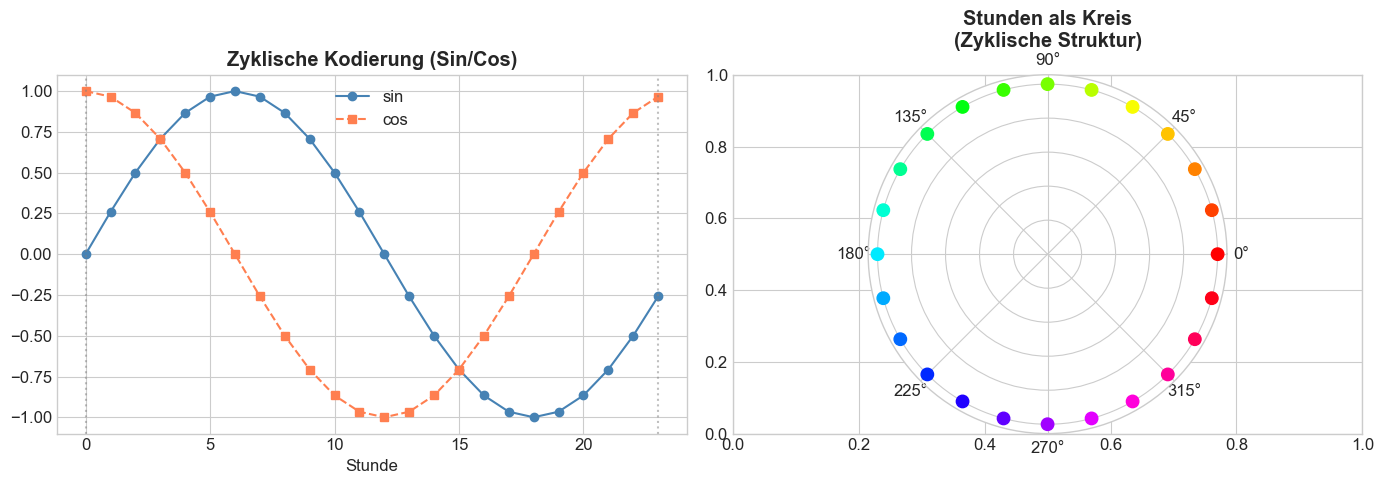

In [92]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

hours = np.arange(24)
axes[0].plot(hours, np.sin(2*np.pi*hours/24), 'o-', color='steelblue', label='sin')
axes[0].plot(hours, np.cos(2*np.pi*hours/24), 's--', color='coral', label='cos')
axes[0].set_title('Zyklische Kodierung (Sin/Cos)', fontweight='bold')
axes[0].set_xlabel('Stunde')
axes[0].legend()
axes[0].axvline(0, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(23, color='gray', linestyle=':', alpha=0.5)

# Polar-Plot: Stunden als Kreis
theta = 2 * np.pi * hours / 24
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
ax2.scatter(theta, np.ones(24), c=hours, cmap='hsv', s=80)
for h in [0, 6, 12, 18]:
    ax2.annotate(f'{h}h', xy=(2*np.pi*h/24, 1.15), fontsize=10, ha='center')
ax2.set_title('Stunden als Kreis\n(Zyklische Struktur)', fontweight='bold', pad=20)
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()

## 🌀 Warum „Stunde“ besser als Kreis statt als Linie behandelt wird

Problem:
- 23 Uhr und 0 Uhr liegen „nebeneinander“,
  aber als Zahl sind sie weit auseinander (23 vs. 0).

Lösung:
- Wir bauen zwei neue Spalten (sin/cos), die die Stunde **wie einen Kreis** darstellen.

Das hilft Modellen zu verstehen:
- „23 Uhr ist nah an 0 Uhr“ (wie auf einer Uhr).

### Hypothese 3 – Rolling-Means als zusätzliche Features

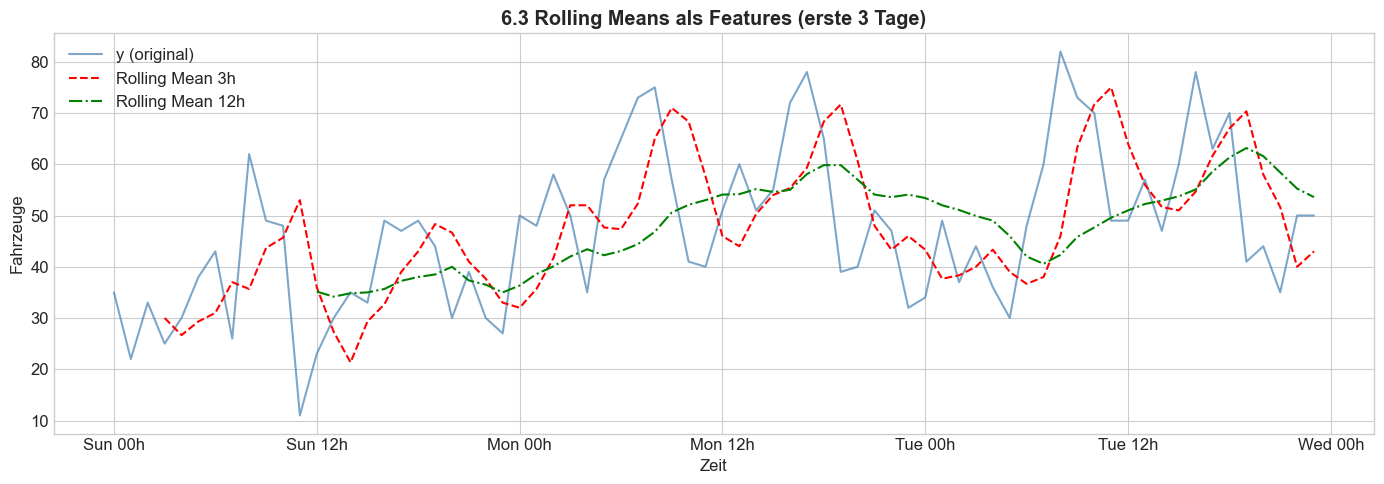

In [93]:
df['rolling_mean_3h']  = df['y'].shift(1).rolling(window=3).mean()
df['rolling_mean_12h'] = df['y'].shift(1).rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['ds'][:72], df['y'][:72], color='steelblue', label='y (original)', alpha=0.7)
ax.plot(df['ds'][:72], df['rolling_mean_3h'][:72], color='red', linestyle='--', label='Rolling Mean 3h')
ax.plot(df['ds'][:72], df['rolling_mean_12h'][:72], color='green', linestyle='-.', label='Rolling Mean 12h')
ax.set_title('6.3 Rolling Means als Features (erste 3 Tage)', fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Fahrzeuge')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %Hh'))
ax.legend()
plt.tight_layout()
plt.show()

---
## 7️⃣ Bewertung der Datenqualität im ML-Kontext

In [94]:
import matplotlib.patches as mpatches

kriterien = {
    'Vollständigkeit':     (5, '🟢 Sehr gut'),
    'Konsistenz':          (5, '🟢 Sehr gut'),
    'Ausreißer':           (5, '🟢 Keine kritischen'),
    'Verteilung':          (5, '🟢 Modellfreundlich'),
    'Saisonalität':        (5, '🟢 Stark ausgeprägt'),
    'Externe Effekte':     (4, '🟡 Messbar vorhanden'),
}

print('📊 Datenqualitätsbewertung im ML-Kontext:\n')
print(f'{"Kriterium":<25} {"Score":>7}  {"Bewertung"}')
print('-' * 55)
for k, (score, label) in kriterien.items():
    print(f'{k:<25} {"★"*score + "☆"*(5-score):>7}  {label}')

print('\n' + '='*55)
print('  🟢 GESAMTBEWERTUNG: Sehr gute Modellierungsgrundlage')
print('='*55)

📊 Datenqualitätsbewertung im ML-Kontext:

Kriterium                   Score  Bewertung
-------------------------------------------------------
Vollständigkeit             ★★★★★  🟢 Sehr gut
Konsistenz                  ★★★★★  🟢 Sehr gut
Ausreißer                   ★★★★★  🟢 Keine kritischen
Verteilung                  ★★★★★  🟢 Modellfreundlich
Saisonalität                ★★★★★  🟢 Stark ausgeprägt
Externe Effekte             ★★★★☆  🟡 Messbar vorhanden

  🟢 GESAMTBEWERTUNG: Sehr gute Modellierungsgrundlage


---
## 8️⃣ Abgeleitete Modellstrategie

In [95]:
print("""
╔══════════════════════════════════════════════════════════╗
║           Empfohlene ML-Pipeline (aus U-Phase)          ║
╠══════════════════════════════════════════════════════════╣
║                                                          ║
║  1. Feature Engineering                                  ║
║     ├─ hour_sin, hour_cos (zyklisch)                    ║
║     ├─ is_weekend                                        ║
║     ├─ lag_1, lag_24                                     ║
║     ├─ rolling_mean_3h, rolling_mean_12h                ║
║     └─ One-Hot-Encoding für weather                      ║
║                                                          ║
║  2. Datenaufteilung                                      ║
║     └─ Chronologischer Train/Test-Split                  ║
║                                                          ║
║  3. Modellvergleich                                      ║
║     ├─ Lineare Regression   (Baseline)                   ║
║     ├─ Random Forest        (robust, nicht-linear)       ║
║     ├─ Gradient Boosting    (Interaktionen)              ║
║     ├─ Prophet              (Saisonalität explizit)      ║
║     └─ LSTM                 (komplexe Zeitabhängigkeiten)║
║                                                          ║
║  4. Evaluation                                           ║
║     ├─ MAE, RMSE, MAPE                                   ║
║     └─ Residualanalyse                                   ║
╚══════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════╗
║           Empfohlene ML-Pipeline (aus U-Phase)          ║
╠══════════════════════════════════════════════════════════╣
║                                                          ║
║  1. Feature Engineering                                  ║
║     ├─ hour_sin, hour_cos (zyklisch)                    ║
║     ├─ is_weekend                                        ║
║     ├─ lag_1, lag_24                                     ║
║     ├─ rolling_mean_3h, rolling_mean_12h                ║
║     └─ One-Hot-Encoding für weather                      ║
║                                                          ║
║  2. Datenaufteilung                                      ║
║     └─ Chronologischer Train/Test-Split                  ║
║                                                          ║
║  3. Modellvergleich                                      ║
║     ├─ Lineare Regression   (Baseline)                   ║
║     ├─ Random Forest    

---
## 9️⃣ Zusammenfassung der U-Phase

### Finaler Feature-Set-Überblick

In [96]:
# Feature-Set final anzeigen
feature_cols = ['ds', 'y', 'hour', 'hour_sin', 'hour_cos',
                'weekday', 'is_weekend', 'month', 'weather',
                'lag_1', 'lag_24', 'rolling_mean_3h', 'rolling_mean_12h']

df_final = df[feature_cols].dropna().reset_index(drop=True)

print(f'📦 Finaler Datensatz nach Feature Engineering:')
print(f'   Shape: {df_final.shape}')
print(f'   Features: {len(feature_cols)-2} (ohne Ziel y und ds)')
print()
display(df_final.head(3))

📦 Finaler Datensatz nach Feature Engineering:
   Shape: (10056, 13)
   Features: 11 (ohne Ziel y und ds)



,ds,y,hour,hour_sin,hour_cos,weekday,is_weekend,month,weather,lag_1,lag_24,rolling_mean_3h,rolling_mean_12h
0,2023-01-02 00:00:00,50,0,0.000000,1.000000,0,0,1,sunny,27.0,35.0,32.000000,36.333333
1,2023-01-02 01:00:00,48,1,0.258819,0.965926,0,0,1,cloudy,50.0,22.0,35.666667,38.583333
2,2023-01-02 02:00:00,58,2,0.500000,0.866025,0,0,1,sunny,48.0,33.0,41.666667,40.083333
